# Emojifier

In this notebook, we will apply the use of word vector representation to build an Emojifier. The Emojifier will convert a sentence like "Congratulations on the new job!" to "Congratulations on the new job!👍" or " Love you!" to "Love you!❤️"

We will first build a simple model using word vector embeddings and then improve its accuracy by incorporating an LSTM.



In [2]:
import numpy as np
from emo_utils import *
import emoji
import matplotlib.pyplot as plt

%matplotlib inline

## 1 - Baseline model: Emojifier-V1

### Dataset EMOJISET

Let's start by building a simple baseline classifier. 

You have a tiny dataset (X, Y) where:
- X contains 132 sentences (strings)
- Y contains a integer label between 0 and 4 corresponding to an emoji for each sentence as below.

These emojies are from the emoji library. Let's create a dictionary of the labels 0 to 4 and corresponding emojies that we'll use.



In [3]:
em_dictionary = {"0": "\u2764\uFE0F",    # :heart: prints a black instead of red heart depending on the font
                    "1": ":baseball:",
                    "2": ":smile:",
                    "3": ":disappointed:",
                    "4": ":fork_and_knife:"}

In [4]:
def convert_label_to_emoji(label):
    """
    Converts a label (int or string) into the corresponding emoji code (string) ready to be printed
    """
    return emoji.emojize(em_dictionary[str(label)], use_aliases=True)

Let's now load our dataset

In [5]:
X_train, Y_train = read_csv('data/train_emoji.csv')
X_test, Y_test = read_csv('data/tesss.csv')

In [6]:
maxLen = len(max(X_train, key=len).split())

Let's try out our dataset and check if the emojies are properly assigned to corresponding labels.

In [7]:

index = 9
print('1:', X_train[index], convert_label_to_emoji(Y_train[index]))

index = 32
print('2:',X_train[index], convert_label_to_emoji(Y_train[index]))

1: I want to go play ⚾
2: do you want to join me for dinner  🍴


Now we will build our basic model first - 
- 1. It takes the a string sentence as an input ans splits them into separated words.
- 2. Then we map each word to its vector embeddings using the Glove Vector data (Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation. [pdf] [bib])
- 3. We take average of the vector embeddings and pass it to a Softmax classifier and determine its class( 0 to 4)
- 4. Based on the class identified returns the emoji for the sentence.

Lets first convert out labels to one-hot vectors.



In [8]:
def conv_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

In [9]:
Y_oh_train = conv_to_one_hot(Y_train, C = 5)
 
Y_oh_test = conv_to_one_hot(Y_test, C = 5)

In [10]:
index = 4
print(Y_train[index], "is converted into one hot", Y_oh_train[index])

4 is converted into one hot [0. 0. 0. 0. 1.]


In [11]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('data/glove.6B.50d.txt')
print(len(word_to_vec_map))

400000


In [12]:

def sentence_to_avg(sentence, word_to_vec_map):
    """
    Converts a sentence (string) into a list of words (strings). Extracts the GloVe representation of each word
    and averages its value into a single vector encoding the meaning of the sentence.
    
    Arguments:
    sentence -- string, one training example from X
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    
    Returns:
    avg -- average vector encoding information about the sentence, numpy-array of shape (50,)
    """
    
    # Step 1: Split sentence into list of lower case words (≈ 1 line)
    words = (sentence.lower()).split() 

    # Initialize the average word vector, should have the same shape as your word vectors.
    avg = np.zeros((50,))
    
    # Step 2: average the word vectors. You can loop over the words in the list "words".
    for w in words:
        avg += word_to_vec_map[w]
    avg = avg /(len(words))
    
    
    return avg

In [13]:
avg = sentence_to_avg("General Tao is my favorite dish", word_to_vec_map)
print("avg = ", avg)

avg =  [-0.01570167  0.47224875 -0.43078167  0.43783167  0.63667833 -0.1715135
 -0.27040602 -0.03558833 -0.23204833 -0.134521    0.05449367  0.417532
  0.18230667  0.12349617  0.23435973  0.02949167 -0.23706683  0.16821167
  0.07462183 -0.146455   -0.17892183 -0.01854333  0.35300915  0.15126777
  0.44729333 -1.23807    -0.65475167  0.037685    0.079911   -0.19847233
  2.60543333  0.00503833 -0.27133667  0.29883333 -0.10645083  0.00723
 -0.06439133  0.62602567  0.16826667 -0.17026833  0.3075545   0.26733667
 -0.440275    0.10890483  0.21151117 -0.008388   -0.126655   -0.29706167
  0.276807    0.44593367]


In [14]:
def model(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 400):
    """
    Model to train word vector representations in numpy.
    
    Arguments:
    X -- input data, numpy array of sentences as strings, of shape (m, 1)
    Y -- labels, numpy array of integers between 0 and 7, numpy-array of shape (m, 1)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    learning_rate -- learning_rate for the stochastic gradient descent algorithm
    num_iterations -- number of iterations
    
    Returns:
    pred -- vector of predictions, numpy-array of shape (m, 1)
    W -- weight matrix of the softmax layer, of shape (n_y, n_h)
    b -- bias of the softmax layer, of shape (n_y,)
    """
    
    np.random.seed(1)

    # Define number of training examples
    m = Y.shape[0]                          # number of training examples
    n_y = 5                                 # number of classes  
    n_h = 50                                # dimensions of the GloVe vectors 
    
    # Initialize parameters using Xavier initialization
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,))
    
    # Convert Y to Y_onehot with n_y classes
    Y_oh = convert_to_one_hot(Y, C = n_y) 
    
    # Optimization loop
    for t in range(num_iterations):                       # Loop over the number of iterations
        for i in range(m):                                # Loop over the training examples
            
            # Average the word vectors of the words from the i'th training example
            avg = sentence_to_avg( X[i] , word_to_vec_map)

            # Forward propagate the avg through the softmax layer
            z = np.dot(W,avg) + b
            a = softmax(z)

            # Compute cost using the i'th training label's one hot representation and "A" (the output of the softmax)
            cost = -1 * np.sum( Y_oh[i] * np.log(a) )
            ### END CODE HERE ###
            
            # Compute gradients 
            dz = a - Y_oh[i]
            dW = np.dot(dz.reshape(n_y,1), avg.reshape(1, n_h))
            db = dz

            # Update parameters with Stochastic Gradient Descent
            W = W - learning_rate * dW
            b = b - learning_rate * db
        
        if t % 100 == 0:
            print("Epoch: " + str(t) + " --- cost = " + str(cost))
            pred = predict(X, Y, W, b, word_to_vec_map)

    return pred, W, b

In [15]:
pred, W, b = model(X_train, Y_train, word_to_vec_map)
#print(pred)

Epoch: 0 --- cost = 1.9520498812810072
Accuracy: 0.3484848484848485
Epoch: 100 --- cost = 0.07971818726014807
Accuracy: 0.9318181818181818
Epoch: 200 --- cost = 0.04456369243681402
Accuracy: 0.9545454545454546
Epoch: 300 --- cost = 0.03432267378786059
Accuracy: 0.9696969696969697


### Examining test set performance 


In [16]:
print("Training set:")
pred_train = predict(X_train, Y_train, W, b, word_to_vec_map)
print('Test set:')
pred_test = predict(X_test, Y_test, W, b, word_to_vec_map)

Training set:
Accuracy: 0.9772727272727273
Test set:
Accuracy: 0.8571428571428571


In [17]:
X_my_sentences = np.array(["i adore you", "i love you", "funny lol", "lets play with a ball", "food is ready", "not feeling happy"])
Y_my_labels = np.array([[0], [0], [2], [1], [4],[3]])

pred = predict(X_my_sentences, Y_my_labels , W, b, word_to_vec_map)
print_predictions(X_my_sentences, pred)

Accuracy: 0.8333333333333334

i adore you ❤️
i love you ❤️
funny lol 😄
lets play with a ball ⚾
food is ready 🍴
not feeling happy 😄


As we can see even though we didnt have the word adore in our training set, the model did correctly predict a heart for it but it failed on the last sentence where "not feeling happy" got a smily face.

Printing the confusion matrix can also help understand which classes are more difficult for our model. 



(56,)
           ❤️    ⚾    😄    😞   🍴
Predicted  0.0  1.0  2.0  3.0  4.0  All
Actual                                 
0            6    0    0    1    0    7
1            0    8    0    0    0    8
2            2    0   16    0    0   18
3            1    1    2   12    0   16
4            0    0    1    0    6    7
All          9    9   19   13    6   56


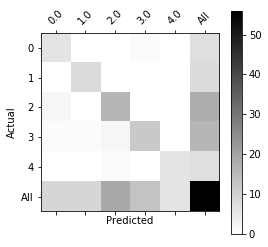

In [18]:
print(Y_test.shape)
print('           '+ label_to_emoji(0)+ '    ' + label_to_emoji(1) + '    ' +  label_to_emoji(2)+ '    ' + label_to_emoji(3)+'   ' + label_to_emoji(4))
print(pd.crosstab(Y_test, pred_test.reshape(56,), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test)

Our model didnt understand the combination of the words like"This is not a happy place" , its just averaging the word vectors. Hence in next part we will modify the model using an LSTM to learn the sentence as a whole, paying attention to the order of the words in it as well as remembering negative words like "no" or "not".



## Emojifier-V2: Using LSTMs in Keras: 



In [20]:
import numpy as np
np.random.seed(0)
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
np.random.seed(1)

### Overview of the model

Here is the Emojifier-v2 that we will implement:

<img src="images/emojifier-v2.png" style="width:700px;height:400px;"> <br>
<caption><center> 



In [21]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples
    
    # Initialize X_indices as a numpy matrix of zeros and the correct shape 
    X_indices = np.zeros((m,max_len))
    
    for i in range(m):                               # loop over training examples
        
        # Convert the ith training sentence in lower case and split is into words.
        sentence_words = (X[i].lower()).split()
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            X_indices[i, j] = word_to_index[w]
            # Increment j to j + 1
            j = j+1
            
    
    return X_indices

In [22]:
#Sanity check

X1 = np.array(["funny lol", "lets play baseball", "food is ready for you"])
X1_indices = sentences_to_indices(X1,word_to_index, max_len = 5)
print("X1 =", X1)
print("X1_indices =", X1_indices)

X1 = ['funny lol' 'lets play baseball' 'food is ready for you']
X1_indices = [[155345. 225122.      0.      0.      0.]
 [220930. 286375.  69714.      0.      0.]
 [151204. 192973. 302254. 151349. 394475.]]


In [23]:

def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index --   dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality  GloVe word vectors 
    
    # Initialize the embedding matrix as a numpy array of zeros of shape 
    # (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len,emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation 
    # of the "index"th word of the vocabulary
    
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct output/input sizes, make it
    # trainable. Use Embedding(...).  
    embedding_layer = Embedding(vocab_len, emb_dim, embeddings_initializer='uniform', 
                                embeddings_regularizer=None, activity_regularizer=None,
                                embeddings_constraint=None, mask_zero=False, input_length=None,
                                trainable = False)

    # Build the embedding layer, it is required before setting the weights of the
    # embedding layer.
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. 
    # Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [24]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
#embedding_layer.get_weights(3321)#[3321]
print("weights[0][1][3] =", embedding_layer.get_weights()[0][1][3])

weights[0][1][3] = -0.3403


## Building the Emojifier-V2



In [25]:

def Emojify_V2(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    # Define sentence_indices as the input of the graph
    
    sentence_indices = Input(input_shape, dtype = 'int32')
    
    # Create the embedding layer pretrained with GloVe Vectors 
    
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer
    
    embeddings = embedding_layer(sentence_indices)   
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
  
    X =  LSTM(128, return_sequences=True )(embeddings) 
                          
    
    # Add dropout with a probability of 0.5
    X = Dropout(0.5, noise_shape=None, seed=None)(X)
    
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    
    
    X = LSTM(128, return_sequences=False )(X)
    
    # Add dropout with a probability of 0.5
    X = Dropout(0.5, noise_shape=None, seed=None)(X)
    # Propagate X through a Dense layer with softmax activation 
    X = Dense(5)(X)
    # Add a softmax activation
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs = sentence_indices, outputs = X)
    
    
    return model

In [26]:
model = Emojify_V2((maxLen,), word_to_vec_map, word_to_index)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 10, 50)            20000050  
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 128)           91648     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
__________

In [27]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [28]:
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
Y_train_oh = conv_to_one_hot(Y_train, C = 5)

In [29]:
model.fit(X_train_indices, Y_train_oh, epochs = 50, batch_size = 32, shuffle=True)

Epoch 1/50
132/132 [==============================] - 4s 28ms/step - loss: 1.6083 - acc: 0.1970
Epoch 2/50
132/132 [==============================] - 0s 1ms/step - loss: 1.5324 - acc: 0.2955
Epoch 3/50
132/132 [==============================] - 0s 1ms/step - loss: 1.5011 - acc: 0.3258
Epoch 4/50
132/132 [==============================] - 0s 1ms/step - loss: 1.4391 - acc: 0.3561
Epoch 5/50
132/132 [==============================] - 0s 1ms/step - loss: 1.3481 - acc: 0.4545A: 0s - loss: 1.3797 - acc: 0.447
Epoch 6/50
132/132 [==============================] - 0s 1ms/step - loss: 1.2347 - acc: 0.5152
Epoch 7/50
132/132 [==============================] - ETA: 0s - loss: 1.2447 - acc: 0.406 - 0s 1ms/step - loss: 1.1768 - acc: 0.4470
Epoch 8/50
132/132 [==============================] - 0s 1ms/step - loss: 1.0551 - acc: 0.5758
Epoch 9/50
132/132 [==============================] - 0s 1ms/step - loss: 0.8778 - acc: 0.7121
Epoch 10/50
132/132 [==============================] - 0s 1ms/step - loss

In [30]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
Y_test_oh = convert_to_one_hot(Y_test, C = 5)
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy = ", acc)

56/56 [==============================] - 0s 8ms/step

Test accuracy =  0.8214285629136222


In [31]:
# This code allows us to see the mislabelled examples
C = 5
y_test_oh = np.eye(C)[Y_test.reshape(-1)]
X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
pred = model.predict(X_test_indices)
for i in range(len(X_test)):
    x = X_test_indices
    num = np.argmax(pred[i])
    if(num != Y_test[i]):
        print('Expected emoji:'+ label_to_emoji(Y_test[i]) + ' prediction: '+ X_test[i] + label_to_emoji(num).strip())

Expected emoji:😄 prediction: she got me a nice present	❤️
Expected emoji:😞 prediction: work is hard	😄
Expected emoji:😞 prediction: This girl is messing with me	❤️
Expected emoji:🍴 prediction: any suggestions for dinner	😄
Expected emoji:❤️ prediction: I love taking breaks	😞
Expected emoji:😄 prediction: you brighten my day	❤️
Expected emoji:😄 prediction: will you be my valentine	❤️
Expected emoji:🍴 prediction: See you at the restaurant	😄
Expected emoji:😞 prediction: go away	⚾
Expected emoji:🍴 prediction: I did not have breakfast ❤️


Let's try on our own sentences

In [35]:

# Change the sentence below to see your prediction. Make sure all the words are in the Glove embeddings.  
x_test = np.array(['nice to see food','I love the Chinese food','I hate my job', 'see you soon','I like the weather'])
#for sent in range(len(x_test)):
X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)

for sent in range(len(x_test)):

    print(x_test[sent] +' '+  label_to_emoji(np.argmax(pred[sent])))

nice to see food 🍴
I love the Chinese food 😞
I hate my job 😄
see you soon ❤️
I like the weather 😄


The baseline Emoji model did not correctly label "not feeling happy," but after modifying it with an LSTM, it got it right. The current model still isn't very robust at understanding negation (like "not happy") because the training set is small and so doesn't have a lot of examples of negation. But if the training set were larger, the LSTM model would be much better than the baseline model at understanding such complex sentences. 


We can use the same model to predict ratings for movies or mobile apps. Just need to replace the emojies with "stars" or "rotten tomatoes" and need a mich larger training set.

References: Inspiration from Coursera.org, Deep Learning Specialization course.